## **Feature Engineering & EDA**
> **목적** : 고객의 인구 정보와 구매 성향을 수치화하여, 이탈 예측 모델 학습 분석을 정교하게 해보자.

1. **고객 프로필 데이터 결합 (Customer Profiling)**
   - `customers.csv`의 나이(Age) 데이터를 결합하고 결측치 처리 및 연령대(Age Group) 변수 생성
2. **상품 선호도 분석 (Product Preference Features)**
   - 고객별 선호 카테고리(Index Name), 평균 구매 가격대 등 행동 패턴 피처 생성
3. **심화 탐색적 데이터 분석 (Deep EDA)**
   - 나이, 구매 가격대, 선호 품목 등 각 피처와 이탈률(Churn Rate) 간의 상관관계 시각화
4. **최종 모델링셋 구축**
   - 학습을 위한 모든 피처가 결합된 마스터 데이터셋(`final_customer_data.csv`) 생성 및 저장


### **1. 고객 프로필 데이터 결합**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# 데이터 불러오기
customers = pd.read_parquet("/content/drive/MyDrive/프로젝트/data//customers.parquet")
rfm = pd.read_csv('/content/drive/MyDrive/프로젝트/data/hm_churn_base .csv')

# 고객 데이터 결합
merged_df=pd.merge(rfm,customers[['customer_id','age']],on='customer_id',how='left')

merged_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customer_id,recency,lifetime_days,frequency,monetary,churn,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,95,450,20,0.598152,0,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,63,579,85,2.574831,0,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,67,576,17,0.643780,0,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,381,0,2,0.060983,1,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,21,600,9,0.340949,0,52.0


#### First step
> 나이(Age) 데이터 상태 확인
- 나이가 비어있는 고객(결측치) *확인*

In [2]:
# 나이 결측치 개수 확인
null_count=merged_df['age'].isnull().sum()
total_count=len(merged_df)
null_percent=(null_count/total_count)*100

print(f"나이 결측치는 {null_count}개 ")
print(f"나이 결측치(%) : 전체의 {null_percent}")

나이 결측치는 15101개 
나이 결측치(%) : 전체의 1.170826184142481


In [3]:
#나이 기초 통계 확인 (최대, 최소 , 평균 나이)
print(merged_df['age'].describe())

count    1.274672e+06
mean     3.652443e+01
std      1.426552e+01
min      1.600000e+01
25%      2.400000e+01
50%      3.200000e+01
75%      4.900000e+01
max      9.900000e+01
Name: age, dtype: float64


*  약 127만명의 고객
*  H&M 고객의 평균 연령대는 30대 중반
* 가장 어린 고객은 16세 청소년
* 가장 나이가 많은 고객은 99세
* 중앙값 32세로 평균 보다 낮은 분포
> 젊은 층이 많이 분포함

#### Second step
> 연령대 그룹화
- 16 ~ 99 세의 범위를 10대, 20대, 30대 ... 처럼 *그룹화*

- 그룹별 이탈률(churn) 확인

In [4]:
from pandas.core.reshape import merge
# 나이 그룹화 함수 정의
def age_group(age):
  if pd.isnull(age): return 'Unknown'
  elif age<20: return '10s'
  elif age<30: return '20s'
  elif age<40: return '30s'
  elif age<50: return '40s'
  elif age<60: return '50s'
  else: return '60s'

# 새로운 컬럼(나이 그룹) 생성
merged_df['age_group']=merged_df['age'].apply(age_group)

# 그룹별 이탈률 확인
age_churn_rate=merged_df.groupby('age_group')['churn'].mean().sort_values(ascending=False)
print("--- 연령대별 이탈률 (높은 순)---")
print(age_churn_rate)

--- 연령대별 이탈률 (높은 순)---
age_group
Unknown    0.850937
60s        0.735491
40s        0.681695
10s        0.674505
30s        0.671346
50s        0.670042
20s        0.605599
Name: churn, dtype: float64


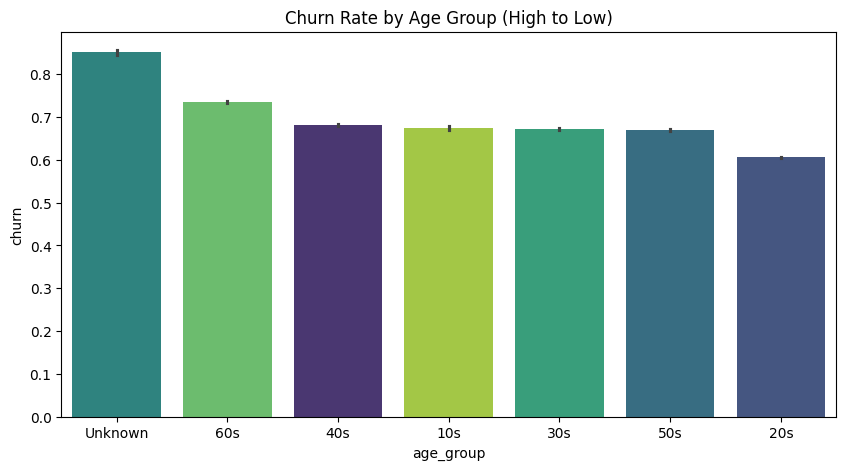

In [18]:
# 연령대별(age_group) 이탈률 시각화
age_order = merged_df.groupby('age_group')['churn'].mean().sort_values(ascending=False).index

plt.figure(figsize=(10, 5))

sns.barplot(
    x='age_group',
    y='churn',
    data=merged_df,
    order=age_order,
    hue='age_group',
    palette='viridis',
    legend=False
)

plt.title('Churn Rate by Age Group (High to Low)')
plt.show()

#### **해석**
1. Unknown 그룹의 위험성 (85%)
- 나이 정보를 입력하지 않은 고객들은 서비스에 대한 충성도가 매우 낮거나, 가입 후 한~두 번 구경하고 떠난 **체리 피커**일 확률이 높음
> "나이 미입력 고객에게 첫 구매 할인 쿠폰을 주면서 정보를 입력하게 유도하자" 제안가능

2. 60대 (73%)
- 20대(60%)에 비해 60대의 이탈률이 높다.
> 패션 플랫폼 H&M 이 중장년층에게 앱 사용성이나 스타일 측면에서 매력이 떨어질 수 있음을 시사함

3. 이탈률이 가장 적은 20대
> H&M 의 핵심 타겟층은 20대이며, 가장 활발하게 서비스를 이용하고 있음

### **2. 상품 선호도 분석**

In [6]:
# articles 데이터 불러오기
articles = pd.read_parquet("/content/drive/MyDrive/프로젝트/data/articles.parquet")
transactions = pd.read_parquet('/content/drive/MyDrive/프로젝트/data/transactions_train.parquet')


고객별 ' 최애 카테고리 ' 찾기

In [7]:
# '어떤 고객이 무슨 옷을 샀는지' 연결
production_action=pd.merge(transactions[['customer_id','article_id']],
                 articles[['article_id','index_name']],
                 on='article_id', how='left')
production_action.head()

,customer_id,article_id,index_name
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,Lingeries/Tights
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,Lingeries/Tights
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,Divided
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,Ladieswear
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,Ladieswear


In [8]:
# 고객별로 각 카테고리를 몇 번씩 샀는지 측정 ( 빈도수 )
cat_counts=production_action.groupby(['customer_id','index_name']).size().reset_index(name='purchase_count')

# 구매 횟수 큰 순서대로 정렬
cat_count=cat_counts.sort_values(['customer_id','purchase_count'],ascending=[True,False])
# 중복되는 고객 ID 버리고, 가장 많이 산 것 남기기
top_cat=cat_counts.drop_duplicates('customer_id')
# 컬럼 이름 변경
top_cat=top_cat.rename(columns={'index_name' : 'favorite_category'})
# 인덱스 0부터 다시 순서대로 지정
top_cat=top_cat.reset_index(drop=True)
print(top_cat.head())

                                         customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                favorite_category  purchase_count  
0  Children Accessories, Swimwear               1  
1                Baby Sizes 50-98               4  
2                         Divided               1  
3                           Sport               2  
4                      Ladieswear               6  


카테고리별 이탈률 계산

 --[팩트체크] 카테고리별 이탈률 현황 --
                                    mean   count
favorite_category                               
Menswear                        0.989055   25216
Sport                           0.982867   11965
Lingeries/Tights                0.945373   60428
Ladieswear                      0.883460  207774
Ladies Accessories              0.759576   68687
Children Sizes 92-140           0.634849   33493
Divided                         0.575113  693074
Children Sizes 134-170          0.543647   74850
Children Accessories, Swimwear  0.520478   41239
Baby Sizes 50-98                0.434693   73047


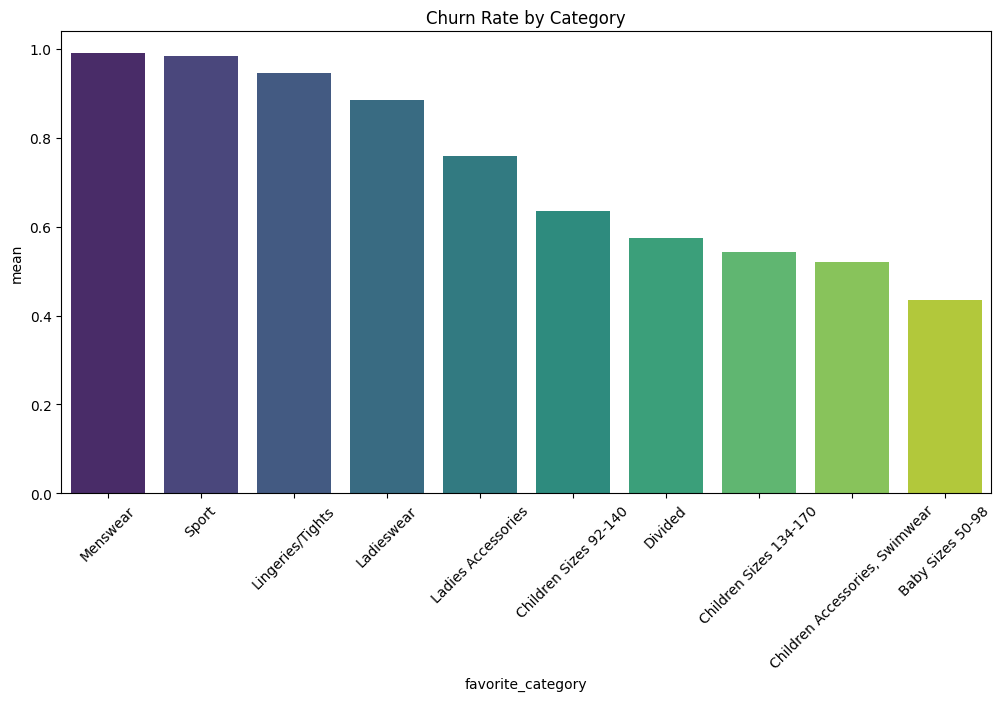

In [20]:
merged_df = pd.merge(merged_df, top_cat[['customer_id', 'favorite_category']], on='customer_id', how='left')


# 합치고 나서 결측치(취향 정보가 없는 고객)는 'Unknown'으로
merged_df['favorite_category'] = merged_df['favorite_category'].fillna('Unknown')
# 카테고리별 이탈률과 고객별 계산
category_analysis = merged_df.groupby('favorite_category')['churn'].agg(['mean','count'])
# 이탈률(mean)이 높은 순서대로 정렬
category_analysis = category_analysis.sort_values(by='mean',ascending=False)

print(" --[팩트체크] 카테고리별 이탈률 현황 --")
print(category_analysis)


plt.figure(figsize=(12, 6))
# 카테고리별 이탈률을 막대 그래프
sns.barplot(x=category_analysis.index,
            y='mean',
            data=category_analysis,
            hue='favorite_category',
            palette='viridis',
            legend=False)
plt.xticks(rotation=45) # 글자가 겹치지 않게 회전
plt.title('Churn Rate by Category')
plt.show()

#### **해석**
1. 남성복 (Menswewar) , 스포츠(Sport) : 이탈률 매우 높음
> H&M 이 남성복이나 스포츠웨어에서는 고객을 붙잡을 매력이 부족하거나, 해당 카테고리 구입 고객들은 '한 번 사고 떠나는' 뜨내기 손님일 확률이 높음

2. 영캐주얼 (Divided) : 고객 수는 가장 많은데 이탈률은 상대적으로 낮음
> Divided 라인이 H&M 의 핵심이고, 고객 유지가 가장 잘 되는 카테고리의 증거

3. 베이비 (Baby Sizes) : 이탈률 최저
> 아기 옷을 사는 부모님들은 한 번 만족하면 계속 구매하는 **충성 고객**이 될 가능성이 가장 높음

- **카테고리별 이탈률 격차**:
    - `Baby Sizes`(43%)와 `Divided`(57%)는 상대적으로 높은 유지율을 보임.
    - 반면, `Menswear`(98%)와 `Sport`(98%)는 극도로 높은 이탈률을 기록하며 비즈니스 취약 구간으로 파악됨.
- **전략적 시사점**: 고객 수가 많고 이탈률이 낮은 `Divided` 고객층을 록인(Lock-in)하는 전략과, 이탈률이 낮은 `Baby` 카테고리로의 고객 유입 확대 전략이 필요함.

고객별 구매력 파악

In [10]:
# 고객별 평균 구매 가격(avg_price)과 총 구매액(total_sum) 계산
price_features = transactions.groupby('customer_id')['price'].agg(['mean', 'sum']).reset_index()
price_features.columns = ['customer_id', 'avg_price', 'total_sum']

# 기존 merged_df에 결합
merged_df = pd.merge(merged_df, price_features, on='customer_id', how='left')

print("--- [확인] 가격 피처 결합 완료 ---")
print(merged_df[['customer_id', 'avg_price', 'total_sum']].head())

--- [확인] 가격 피처 결합 완료 ---
                                         customer_id  avg_price  total_sum
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   0.030904   0.648983
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   0.030255   2.601932
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   0.039154   0.704780
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   0.030492   0.060983
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   0.036130   0.469695


In [11]:
merged_df.head()

,customer_id,recency,lifetime_days,frequency,monetary,churn,age,age_group,favorite_category,avg_price,total_sum
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,95,450,20,0.598152,0,49.0,40s,"Children Accessories, Swimwear",0.030904,0.648983
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,63,579,85,2.574831,0,25.0,20s,Baby Sizes 50-98,0.030255,2.601932
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,67,576,17,0.643780,0,24.0,20s,Divided,0.039154,0.704780
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,381,0,2,0.060983,1,54.0,50s,Sport,0.030492,0.060983
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,21,600,9,0.340949,0,52.0,50s,Ladieswear,0.036130,0.469695


### **어떤 변수가 churn(이탈)과 가장 관련이 깊은지 파악**

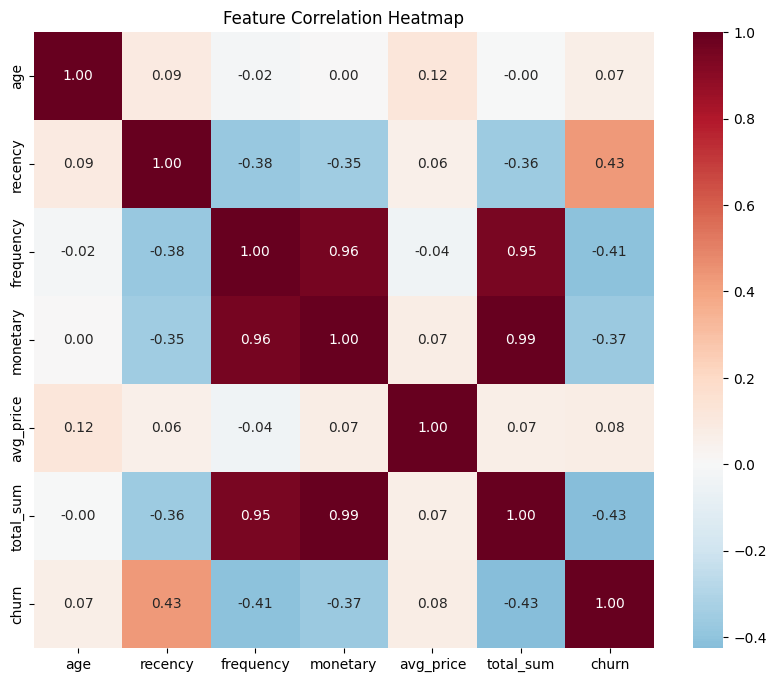

In [12]:
# 수치형 변수들 선택
features = ['age', 'recency', 'frequency', 'monetary', 'avg_price', 'total_sum', 'churn']
corr = merged_df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

###  상관관계 분석 결과
1. `Recency(최근성)`가 이탈과 가장 높은 양의 상관관계(0.43)를 보임. 즉, 휴면 기간이 길어지는 고객에 대한 즉각적인 타겟 마케팅이 필요함.
2. `Total_sum(기여도)`이 높을수록 이탈률은 낮아지며(-0.43), 이는 VIP 고객 관리가 유지율(Retention)에 핵심임을 시사함.
3. **다중공선성 확인**: Frequency와 Monetary 간의 상관관계가 0.95 이상으로 매우 높으므로, 향후 모델링 시 변수 선택(Feature Selection) 과정이 필요함.

In [13]:
# 최종 데이터 저장
merged_df.to_csv('final_data.csv', index=False)